In [1]:
from spectral_cube import SpectralCube
#from pvextractor import extract_pv_slice, Path
#import pylab as pl
import numpy as np
from astropy.visualization import quantity_support
from astropy import units as u
from astropy import wcs
#from matplotlib.colors import LogNorm
#from astropy.visualization.stretch import SinhStretch
#from astropy.visualization import simple_norm
import matplotlib.pyplot as plt
from astropy.utils import data
from reproject import reproject_exact
from astropy.io import fits
from reproject.mosaicking import find_optimal_celestial_wcs
from astropy.coordinates import SkyCoord
from astropy.coordinates import ICRS, Galactic, FK4, FK5  # Low-level frames
from astropy.coordinates import Angle, Latitude, Longitude  # Angles

fatal: detected dubious ownership in repository at '/blue/adamginsburg/adamginsburg/repos/dask'
To add an exception for this directory, call:

	git config --global --add safe.directory /blue/adamginsburg/adamginsburg/repos/dask


In [2]:
feather_file = '/orange/adamginsburg/cmz/g5/G5/a/feather/spw29.13CO/g5a.feather.13CO.image'
cube_feather = SpectralCube.read(feather_file, format='casa_image').with_spectral_unit(u.km/u.s, velocity_convention='radio').to(u.K)

/blue/adamginsburg/adamginsburg/repos/casa-formats-io/casa_formats_io/casa_dask.py:247: RuntimeWarning: divide by zero encountered in long_scalars
  factors = [f for f in range(stacks[dim] + 1) if stacks[dim] % f == 0]


In [3]:
combo_fixednames = [
    '/orange/adamginsburg/cmz/g5/G5/sum/newcombination/galcorrected/g5.12CO.spw17.fits',
    'lol',
    #'/orange/adamginsburg/cmz/g5/G5/sum/newcombination/galcorrected/g5.CH3OH.spw21.fits',
    '/orange/adamginsburg/cmz/g5/G5/sum/newcombination/galcorrected/g5.CH3OH.masked.spw21.fits',
    '/orange/adamginsburg/cmz/g5/G5/sum/newcombination/galcorrected/g5.H2CO.spw23.fits',
    '/orange/adamginsburg/cmz/g5/G5/sum/newcombination/galcorrected/g5.H2CO.spw25.fits',
    '/orange/adamginsburg/cmz/g5/G5/sum/newcombination/galcorrected/g5.SiO.spw27.fits',
    '/orange/adamginsburg/cmz/g5/G5/sum/newcombination/galcorrected/g5.13CO.spw29.fits',
    '/orange/adamginsburg/cmz/g5/G5/sum/newcombination/galcorrected/g5.C18O.spw31.fits'
    ]

cube_17 = SpectralCube.read(combo_fixednames[0]).with_spectral_unit(u.km/u.s, velocity_convention='radio')
cube_21 = SpectralCube.read(combo_fixednames[2]).with_spectral_unit(u.km/u.s, velocity_convention='radio')
cube_23 = SpectralCube.read(combo_fixednames[3]).with_spectral_unit(u.km/u.s, velocity_convention='radio')
cube_25 = SpectralCube.read(combo_fixednames[4]).with_spectral_unit(u.km/u.s, velocity_convention='radio')
cube_27 = SpectralCube.read(combo_fixednames[5]).with_spectral_unit(u.km/u.s, velocity_convention='radio')
cube_29 = SpectralCube.read(combo_fixednames[6]).with_spectral_unit(u.km/u.s, velocity_convention='radio')
cube_31 = SpectralCube.read(combo_fixednames[7]).with_spectral_unit(u.km/u.s, velocity_convention='radio')

In [4]:
def noise_mask(cube, vmin, vmax, level):
    noise = cube.with_spectral_unit(u.km/u.s, velocity_convention='radio').spectral_slab(vmin, vmax).std(axis=0)
    peak = cube.max(axis=0)
    spatial_mask = peak > level * noise
    return spatial_mask

def noise_mask_slab(cube, vmin, vmax, level, cut1, cut2):
    noise = cube.with_spectral_unit(u.km/u.s, velocity_convention='radio').spectral_slab(vmin, vmax).std(axis=0)
    peak = cube.spectral_slab(cut1, cut2).max(axis=0)
    spatial_mask = peak > level * noise
    return spatial_mask

In [5]:
cube_17.allow_huge_operations=True

In [6]:
mask_17 = noise_mask(cube_17, -100*u.km/u.second, -50 *u.km/u.second, 5)
mask_23 = noise_mask(cube_23, 180*u.km/u.second, 220 *u.km/u.second, 5)
mask_25 = noise_mask(cube_25, -100*u.km/u.second, -50 *u.km/u.second, 5)
mask_27 = noise_mask(cube_27, -100*u.km/u.second, -50 *u.km/u.second, 5)
mask_29 = noise_mask(cube_29, -100*u.km/u.second, -50 *u.km/u.second, 5)
mask_31 = noise_mask(cube_31, -100*u.km/u.second, -50 *u.km/u.second, 5)

/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/blue/adamginsburg/adamginsburg/repos/spectral-cube/spectral_cube/spectral_cube.py:537: RuntimeWarning: All-NaN slice encountered
  result = function(np.dstack((result, plane)), axis=2, **kwargs)
/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/blue/adamginsburg/adamginsburg/repos/spectral-cube/spectral_cube/spectral_cube.py:439: RuntimeWarning: All-NaN slice encountered
  out = function(self._get_filled_data(fill=fill,
/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, 

In [7]:
cube_17b = cube_17.spectral_slab(15*u.km / u.second, 75*u.km/u.second)
mask_17b = noise_mask_slab(cube_17, -100*u.km/u.second, -50 *u.km/u.second, 5, 15*u.km / u.second, 75*u.km/u.second)

cube_17a = cube_17.spectral_slab(75*u.km / u.second, 200*u.km/u.second)
mask_17a = noise_mask_slab(cube_17, -100*u.km/u.second, -50 *u.km/u.second, 5, 75*u.km / u.second, 200*u.km/u.second)

/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/blue/adamginsburg/adamginsburg/repos/spectral-cube/spectral_cube/spectral_cube.py:439: RuntimeWarning: All-NaN slice encountered
  out = function(self._get_filled_data(fill=fill,
/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/blue/adamginsburg/adamginsburg/repos/spectral-cube/spectral_cube/spectral_cube.py:439: RuntimeWarning: All-NaN slice encountered
  out = function(self._get_filled_data(fill=fill,


In [8]:
d = 7*u.kpc
m = 3*u.pc

ang = ((m / d)*u.radian).to(u.deg, equivalencies=u.dimensionless_angles())
ang

<Quantity 0.02455533 deg>

INFO: Auto-setting vmin to -8.406e+00 [aplpy.core]
INFO: Auto-setting vmax to  5.518e+01 [aplpy.core]
INFO: Auto-setting vmin to -8.022e+00 [aplpy.core]
INFO: Auto-setting vmax to  5.577e+01 [aplpy.core]


/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/aplpy/overlays.py:272: UserWarning: Scalebar does not have attribute size. Skipping.
  warnings.warn("Scalebar does not have attribute {0}. Skipping.".format(kwarg))


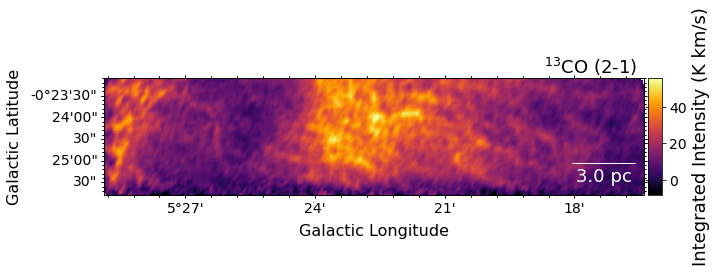

In [9]:
cubefeather_0 = cube_feather.spectral_slab(15*u.km / u.second, 200*u.km/u.second).moment0()
cubefeather_0.quicklook()
cubefeather_0.FITSFigure.show_colorscale(cmap='inferno')
cubefeather_0.FITSFigure.colorbar.set_axis_label_text('Integrated Intensity (K km/s)')
#cubefeather_0.FITSFigure.show_contour(cubefeather_0.hdu, returnlevels=True)
cubefeather_0.FITSFigure.colorbar.set_axis_label_font(size=18)
cubefeather_0.FITSFigure.colorbar.set_font(size=14)
cubefeather_0.FITSFigure.axis_labels.set_font(size=16)
cubefeather_0.FITSFigure.tick_labels.set_font(size=14)
cubefeather_0.FITSFigure.add_label(0.9, 1.1, "$^{13}$CO (2-1)", relative=True, size=18)
cubefeather_0.FITSFigure.add_scalebar(ang, color='white', size=18)
cubefeather_0.FITSFigure.scalebar.set_label(m)
#cube17_0.FITSFigure.show_regions('/orange/adamginsburg/cmz/g5/code/g5-lowvelo.reg')
#cube17_0.FITSFigure.show_regions('/orange/adamginsburg/cmz/g5/code/g5-highvelo.reg')
#cube17_0.FITSFigure.savefig('/orange/adamginsburg/cmz/g5/code/plots/mom0_17-new.pdf')

INFO: Auto-setting vmin to  1.678e-01 [aplpy.core]
INFO: Auto-setting vmax to  2.272e+00 [aplpy.core]
INFO: Auto-setting vmin to  1.631e-01 [aplpy.core]
INFO: Auto-setting vmax to  2.414e+00 [aplpy.core]


/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/aplpy/overlays.py:272: UserWarning: Scalebar does not have attribute size. Skipping.
  warnings.warn("Scalebar does not have attribute {0}. Skipping.".format(kwarg))


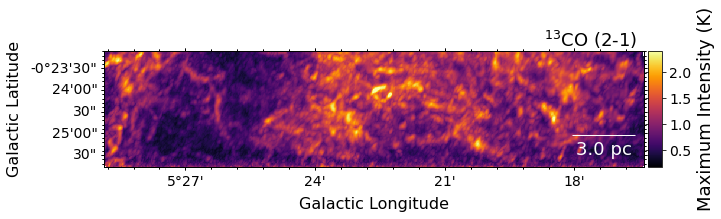

In [10]:
cubefeather_max = cube_feather.spectral_slab(15*u.km / u.second, 200*u.km/u.second).max(axis=0)
cubefeather_max.quicklook()
cubefeather_max.FITSFigure.show_colorscale(cmap='inferno')
cubefeather_max.FITSFigure.colorbar.set_axis_label_text('Maximum Intensity (K)')
#cubefeather_max.FITSFigure.show_contour(cubefeather_0.hdu, returnlevels=True)
cubefeather_max.FITSFigure.colorbar.set_axis_label_font(size=18)
cubefeather_max.FITSFigure.colorbar.set_font(size=14)
cubefeather_max.FITSFigure.axis_labels.set_font(size=16)
cubefeather_max.FITSFigure.tick_labels.set_font(size=14)
cubefeather_max.FITSFigure.add_label(0.9, 1.1, "$^{13}$CO (2-1)", relative=True, size=18)
cubefeather_max.FITSFigure.add_scalebar(ang, color='white', size=18)
cubefeather_max.FITSFigure.scalebar.set_label(m)
#cube17_0.FITSFigure.show_regions('/orange/adamginsburg/cmz/g5/code/g5-lowvelo.reg')
#cube17_0.FITSFigure.show_regions('/orange/adamginsburg/cmz/g5/code/g5-highvelo.reg')
#cube17_0.FITSFigure.savefig('/orange/adamginsburg/cmz/g5/code/plots/mom0_17-new.pdf')

In [11]:
coord = SkyCoord(5.413*u.deg, -22.35*u.arcmin, frame=Galactic)
coord.to_pixel(wcs=cube_17.wcs)

(array(90.62286259), array(75.4199441))

INFO: Auto-setting vmin to -1.247e+02 [aplpy.core]
INFO: Auto-setting vmax to  8.488e+02 [aplpy.core]
INFO: Auto-setting vmin to -6.269e+01 [aplpy.core]
INFO: Auto-setting vmax to  8.428e+02 [aplpy.core]


/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/aplpy/overlays.py:272: UserWarning: Scalebar does not have attribute size. Skipping.
  warnings.warn("Scalebar does not have attribute {0}. Skipping.".format(kwarg))


INFO: Auto-setting resolution to 37.2333 dpi [aplpy.core]


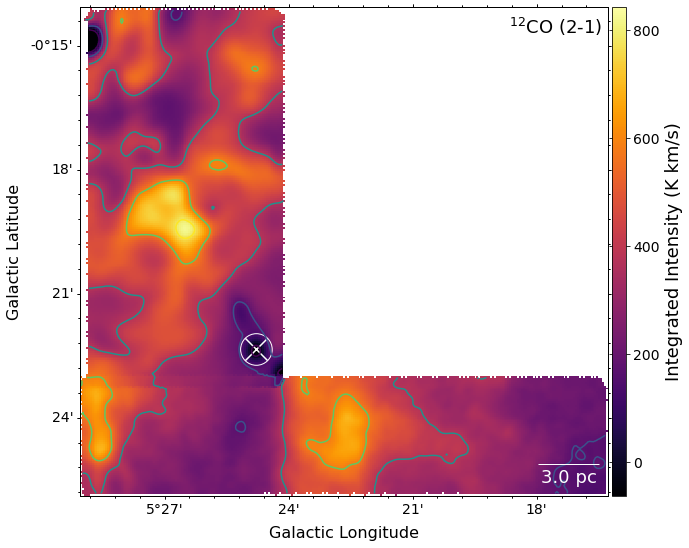

In [12]:
cube17_0 = cube_17.with_mask(mask_17).spectral_slab(15*u.km / u.second, 200*u.km/u.second).moment0()
cube17_0.quicklook()
cube17_0.FITSFigure.show_colorscale(cmap='inferno')
cube17_0.FITSFigure.colorbar.set_axis_label_text('Integrated Intensity (K km/s)')
cube17_0.FITSFigure.show_contour(cube17_0.hdu, returnlevels=True)
cube17_0.FITSFigure.colorbar.set_axis_label_font(size=18)
cube17_0.FITSFigure.colorbar.set_font(size=14)
cube17_0.FITSFigure.axis_labels.set_font(size=16)
cube17_0.FITSFigure.tick_labels.set_font(size=14)
cube17_0.FITSFigure.add_label(0.9, 0.96, "$^{12}$CO (2-1)", relative=True, size=18)
cube17_0.FITSFigure.add_scalebar(ang, color='white', size=18)
cube17_0.FITSFigure.scalebar.set_label(m)
#cube17_0.FITSFigure.show_regions('/orange/adamginsburg/cmz/g5/code/g5-lowvelo.reg')
#cube17_0.FITSFigure.show_regions('/orange/adamginsburg/cmz/g5/code/g5-highvelo.reg')
cube17_0.FITSFigure.show_markers(coord.to_pixel(wcs=cube17_0.wcs)[0], coord.to_pixel(wcs=cube17_0.wcs)[1], coords_frame='pixel', layer=True, c='none', edgecolor='white', s=1000)
cube17_0.FITSFigure.show_markers(coord.l, coord.b, marker='x', c='white', s=500)
cube17_0.FITSFigure.savefig('/orange/adamginsburg/cmz/g5/code/plots/mom0_17-new.pdf')

/blue/adamginsburg/adamginsburg/repos/spectral-cube/spectral_cube/spectral_cube.py:439: RuntimeWarning: All-NaN slice encountered
  out = function(self._get_filled_data(fill=fill,


INFO: Auto-setting vmin to  2.742e+00 [aplpy.core]
INFO: Auto-setting vmax to  1.721e+01 [aplpy.core]
INFO: Auto-setting vmin to  2.734e+00 [aplpy.core]
INFO: Auto-setting vmax to  1.783e+01 [aplpy.core]


/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/aplpy/overlays.py:272: UserWarning: Scalebar does not have attribute size. Skipping.
  warnings.warn("Scalebar does not have attribute {0}. Skipping.".format(kwarg))


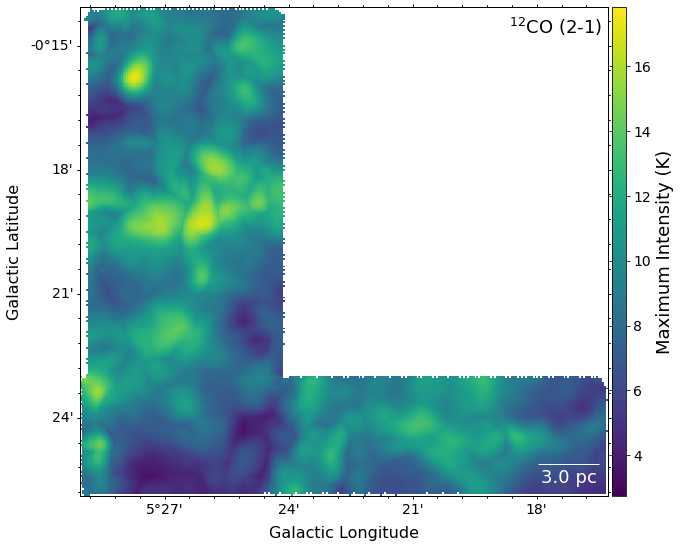

In [13]:
cube17_max = cube_17.with_mask(mask_17).spectral_slab(15*u.km / u.second, 200*u.km/u.second).max(axis=0)
cube17_max.quicklook()
cube17_max.FITSFigure.show_colorscale(cmap='viridis')
cube17_max.FITSFigure.colorbar.set_axis_label_text('Maximum Intensity (K)')
#cube17_max.FITSFigure.show_contour(cube17_0.hdu, returnlevels=True)
cube17_max.FITSFigure.colorbar.set_axis_label_font(size=18)
cube17_max.FITSFigure.colorbar.set_font(size=14)
cube17_max.FITSFigure.axis_labels.set_font(size=16)
cube17_max.FITSFigure.tick_labels.set_font(size=14)
cube17_max.FITSFigure.add_label(0.9, 0.96, "$^{12}$CO (2-1)", relative=True, size=18)
cube17_max.FITSFigure.add_scalebar(ang, color='white', size=18)
cube17_max.FITSFigure.scalebar.set_label(m)


/blue/adamginsburg/adamginsburg/repos/spectral-cube/spectral_cube/_moments.py:168: RuntimeWarning: invalid value encountered in divide
  return (np.nansum(data * pix_cen, axis=axis) /


INFO: Auto-setting vmin to -1.217e+01 [aplpy.core]
INFO: Auto-setting vmax to  1.799e+02 [aplpy.core]
INFO: Auto-setting vmin to  2.042e+01 [aplpy.core]


/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/aplpy/overlays.py:272: UserWarning: Scalebar does not have attribute size. Skipping.
  warnings.warn("Scalebar does not have attribute {0}. Skipping.".format(kwarg))


INFO: Auto-setting resolution to 37.2333 dpi [aplpy.core]


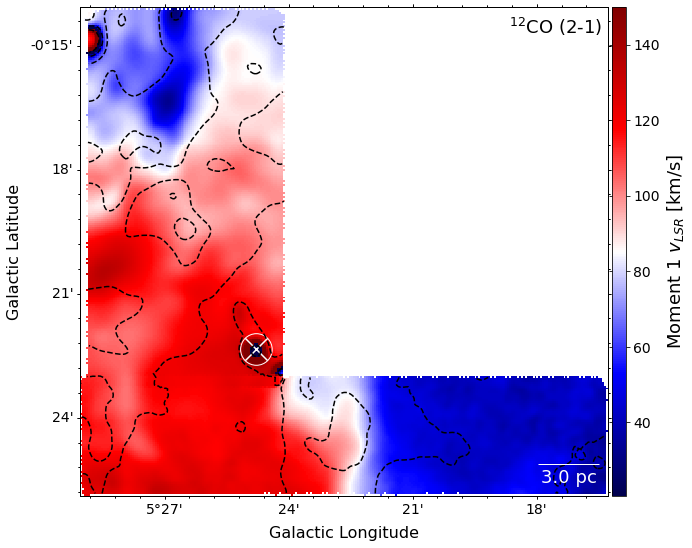

In [14]:
cube17_1 = cube_17.with_mask(mask_17).spectral_slab(15*u.km / u.second, 200*u.km/u.second).moment1()
cube17_1.quicklook()
cube17_1.FITSFigure.show_colorscale(cmap='seismic', vmax=150)
cube17_1.FITSFigure.colorbar.set_axis_label_text('Moment 1 $v_{LSR}$ [km/s]')
cube17_1.FITSFigure.show_contour(cube17_0.hdu, returnlevels=True, linestyles='dashed', colors='black')
cube17_1.FITSFigure.colorbar.set_axis_label_font(size=18)
cube17_1.FITSFigure.colorbar.set_font(size=14)
cube17_1.FITSFigure.axis_labels.set_font(size=16)
cube17_1.FITSFigure.tick_labels.set_font(size=14)
cube17_1.FITSFigure.add_label(0.9, 0.96, "$^{12}$CO (2-1)", relative=True, size=18)
cube17_1.FITSFigure.add_scalebar(ang, color='white', size=18)
cube17_1.FITSFigure.scalebar.set_label(m)
cube17_1.FITSFigure.show_markers(coord.to_pixel(wcs=cube17_1.wcs)[0], coord.to_pixel(wcs=cube17_1.wcs)[1], coords_frame='pixel', layer=True, c='none', edgecolor='white', s=1000)
cube17_1.FITSFigure.show_markers(coord.l, coord.b, marker='x', c='white', s=500)
cube17_1.FITSFigure.savefig('/orange/adamginsburg/cmz/g5/code/plots/mom1_17-new.pdf')

INFO: Auto-setting vmin to -9.634e-01 [aplpy.core]
INFO: Auto-setting vmax to  1.479e+02 [aplpy.core]
INFO: Auto-setting vmin to -3.369e+00 [aplpy.core]
INFO: Auto-setting vmax to  1.480e+02 [aplpy.core]


/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/aplpy/overlays.py:272: UserWarning: Scalebar does not have attribute size. Skipping.
  warnings.warn("Scalebar does not have attribute {0}. Skipping.".format(kwarg))


INFO: Auto-setting resolution to 37.2333 dpi [aplpy.core]


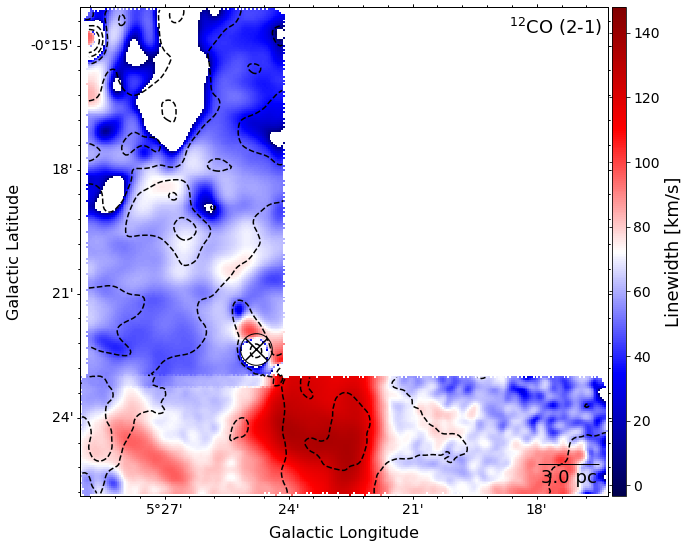

In [15]:
cube17_2 = cube_17.with_mask(mask_17).spectral_slab(15*u.km / u.second, 200*u.km/u.second).linewidth_fwhm()
cube17_2.quicklook()
cube17_2.FITSFigure.show_colorscale(cmap='seismic')
cube17_2.FITSFigure.colorbar.set_axis_label_text('Linewidth [km/s]')
cube17_2.FITSFigure.show_contour(cube17_0.hdu, returnlevels=True, linestyles='dashed', colors='black')
cube17_2.FITSFigure.colorbar.set_axis_label_font(size=18)
cube17_2.FITSFigure.colorbar.set_font(size=14)
cube17_2.FITSFigure.axis_labels.set_font(size=16)
cube17_2.FITSFigure.tick_labels.set_font(size=14)
cube17_2.FITSFigure.add_label(0.9, 0.96, "$^{12}$CO (2-1)", relative=True, size=18)
cube17_2.FITSFigure.add_scalebar(ang, color='black', size=18)
cube17_2.FITSFigure.scalebar.set_label(m)
cube17_2.FITSFigure.show_markers(coord.to_pixel(wcs=cube17_2.wcs)[0], coord.to_pixel(wcs=cube17_2.wcs)[1], coords_frame='pixel', layer=True, c='none', edgecolor='black', s=1000)
cube17_2.FITSFigure.show_markers(coord.l, coord.b, marker='x', c='black', s=500)
cube17_2.FITSFigure.savefig('/orange/adamginsburg/cmz/g5/code/plots/mom2_17-new.pdf')

INFO: Auto-setting vmin to -2.460e+02 [aplpy.core]
INFO: Auto-setting vmax to  7.434e+02 [aplpy.core]
INFO: Auto-setting vmin to -9.250e+01 [aplpy.core]
INFO: Auto-setting vmax to  7.183e+02 [aplpy.core]


/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/aplpy/overlays.py:272: UserWarning: Scalebar does not have attribute size. Skipping.
  warnings.warn("Scalebar does not have attribute {0}. Skipping.".format(kwarg))


INFO: Auto-setting resolution to 37.2333 dpi [aplpy.core]


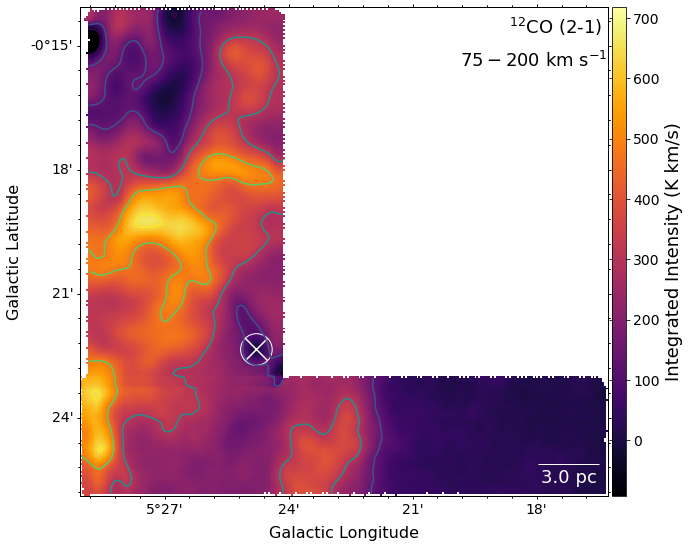

In [16]:
cube17a_0 = cube_17a.with_mask(mask_17a).moment0()
cube17a_0.quicklook()
cube17a_0.FITSFigure.show_colorscale(cmap='inferno')
cube17a_0.FITSFigure.colorbar.set_axis_label_text('Integrated Intensity (K km/s)')
cube17a_0.FITSFigure.show_contour(cube17a_0.hdu, returnlevels=True)
cube17a_0.FITSFigure.colorbar.set_axis_label_font(size=18)
cube17a_0.FITSFigure.colorbar.set_font(size=14)
cube17a_0.FITSFigure.axis_labels.set_font(size=16)
cube17a_0.FITSFigure.tick_labels.set_font(size=14)
cube17a_0.FITSFigure.add_label(0.9, 0.96, "$^{12}$CO (2-1)", relative=True, size=18)
cube17a_0.FITSFigure.add_label(0.86, 0.89, "$75-200$ km s$^{-1}$", relative=True, size=18)
cube17a_0.FITSFigure.add_scalebar(ang, color='white', size=18)
cube17a_0.FITSFigure.scalebar.set_label(m)
cube17a_0.FITSFigure.show_markers(coord.to_pixel(wcs=cube17a_0.wcs)[0], coord.to_pixel(wcs=cube17a_0.wcs)[1], coords_frame='pixel', layer=True, c='none', edgecolor='white', s=1000)
cube17a_0.FITSFigure.show_markers(coord.l, coord.b, marker='x', c='white', s=500)
cube17a_0.FITSFigure.savefig('/orange/adamginsburg/cmz/g5/code/plots/mom0_G5a_17-new.pdf')

/blue/adamginsburg/adamginsburg/repos/spectral-cube/spectral_cube/spectral_cube.py:439: RuntimeWarning: All-NaN slice encountered
  out = function(self._get_filled_data(fill=fill,


INFO: Auto-setting vmin to -1.373e+00 [aplpy.core]
INFO: Auto-setting vmax to  1.736e+01 [aplpy.core]


/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/aplpy/overlays.py:272: UserWarning: Scalebar does not have attribute size. Skipping.
  warnings.warn("Scalebar does not have attribute {0}. Skipping.".format(kwarg))


INFO: Auto-setting vmin to -1.421e+00 [aplpy.core]
INFO: Auto-setting vmax to  1.760e+01 [aplpy.core]


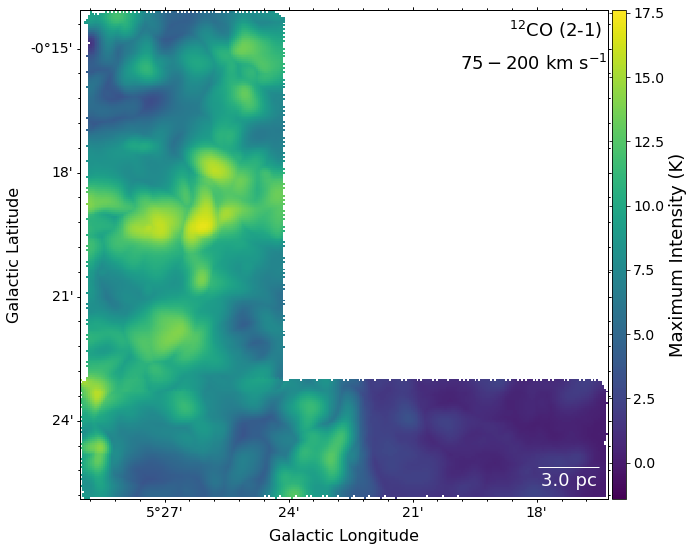

In [17]:
cube17a_max = cube_17a.with_mask(mask_17a).max(axis=0)
cube17a_max.quicklook()
cube17a_max.FITSFigure.show_colorscale(cmap='viridis')
cube17a_max.FITSFigure.colorbar.set_axis_label_text('Maximum Intensity (K)')
#cube17a_max.FITSFigure.show_contour(cube17a_0.hdu, returnlevels=True)
cube17a_max.FITSFigure.colorbar.set_axis_label_font(size=18)
cube17a_max.FITSFigure.colorbar.set_font(size=14)
cube17a_max.FITSFigure.axis_labels.set_font(size=16)
cube17a_max.FITSFigure.tick_labels.set_font(size=14)
cube17a_max.FITSFigure.add_label(0.9, 0.96, "$^{12}$CO (2-1)", relative=True, size=18)
cube17a_max.FITSFigure.add_label(0.86, 0.89, "$75-200$ km s$^{-1}$", relative=True, size=18)
cube17a_max.FITSFigure.add_scalebar(ang, color='white', size=18)
cube17a_max.FITSFigure.scalebar.set_label(m)
#cube17a_0.FITSFigure.savefig('/orange/adamginsburg/cmz/g5/code/plots/mom0_G5a_17-new.pdf')

INFO: Auto-setting vmin to -7.443e+01 [aplpy.core]
INFO: Auto-setting vmax to  4.575e+02 [aplpy.core]
INFO: Auto-setting vmin to -7.123e+01 [aplpy.core]
INFO: Auto-setting vmax to  4.579e+02 [aplpy.core]


/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/aplpy/overlays.py:272: UserWarning: Scalebar does not have attribute size. Skipping.
  warnings.warn("Scalebar does not have attribute {0}. Skipping.".format(kwarg))


INFO: Auto-setting resolution to 37.2333 dpi [aplpy.core]


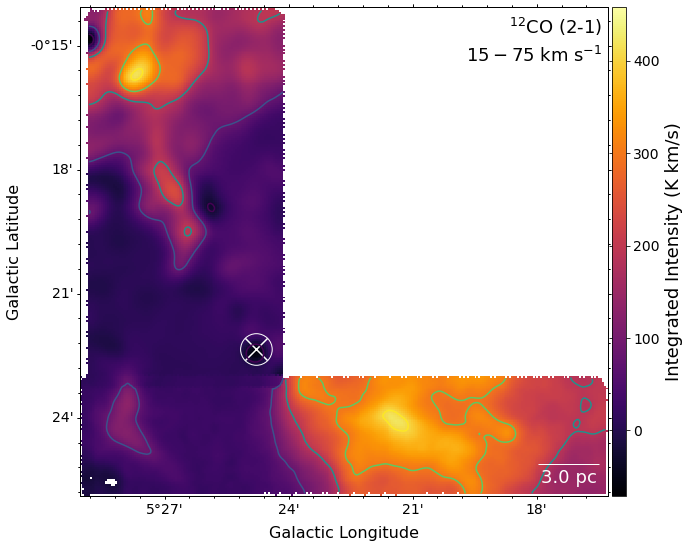

In [18]:
cube17b_0 = cube_17b.with_mask(mask_17b).moment0()
cube17b_0.quicklook()
cube17b_0.FITSFigure.show_colorscale(cmap='inferno')
cube17b_0.FITSFigure.colorbar.set_axis_label_text('Integrated Intensity (K km/s)')
cube17b_0.FITSFigure.show_contour(cube17b_0.hdu, returnlevels=True)
cube17b_0.FITSFigure.colorbar.set_axis_label_font(size=18)
cube17b_0.FITSFigure.colorbar.set_font(size=14)
cube17b_0.FITSFigure.axis_labels.set_font(size=16)
cube17b_0.FITSFigure.tick_labels.set_font(size=14)
cube17b_0.FITSFigure.add_label(0.9, 0.96, "$^{12}$CO (2-1)", relative=True, size=18)
cube17b_0.FITSFigure.add_label(0.86, 0.9, "$15-75$ km s$^{-1}$", relative=True, size=18)
cube17b_0.FITSFigure.add_scalebar(ang, color='white', size=18)
cube17b_0.FITSFigure.scalebar.set_label(m)
cube17b_0.FITSFigure.show_markers(coord.to_pixel(wcs=cube17b_0.wcs)[0], coord.to_pixel(wcs=cube17b_0.wcs)[1], coords_frame='pixel', layer=True, c='none', edgecolor='white', s=1000)
cube17b_0.FITSFigure.show_markers(coord.l, coord.b, marker='x', c='white', s=500)
cube17b_0.FITSFigure.savefig('/orange/adamginsburg/cmz/g5/code/plots/mom0_G5b_17-new.pdf')

/blue/adamginsburg/adamginsburg/repos/spectral-cube/spectral_cube/spectral_cube.py:439: RuntimeWarning: All-NaN slice encountered
  out = function(self._get_filled_data(fill=fill,


INFO: Auto-setting vmin to -1.219e+00 [aplpy.core]
INFO: Auto-setting vmax to  1.643e+01 [aplpy.core]
INFO: Auto-setting vmin to -1.178e+00 [aplpy.core]
INFO: Auto-setting vmax to  1.642e+01 [aplpy.core]


/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/aplpy/overlays.py:272: UserWarning: Scalebar does not have attribute size. Skipping.
  warnings.warn("Scalebar does not have attribute {0}. Skipping.".format(kwarg))


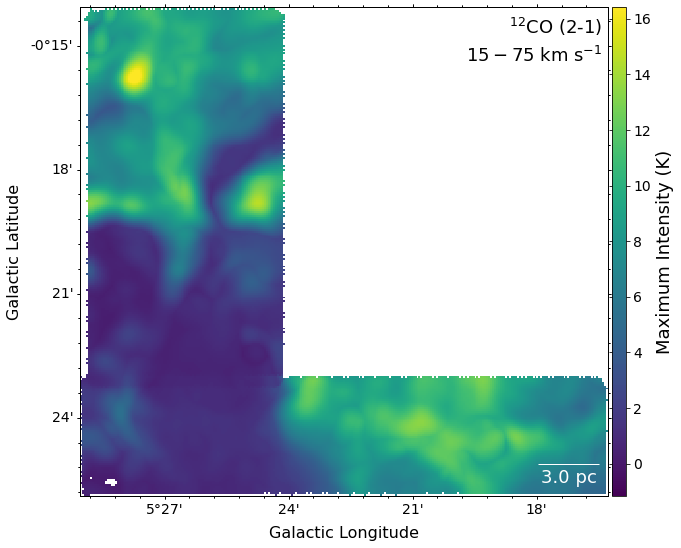

In [19]:
cube17b_max = cube_17b.with_mask(mask_17b).max(axis=0)
cube17b_max.quicklook()
cube17b_max.FITSFigure.show_colorscale(cmap='viridis')
cube17b_max.FITSFigure.colorbar.set_axis_label_text('Maximum Intensity (K)')
#cube17b_max.FITSFigure.show_contour(cube17b_0.hdu, returnlevels=True)
cube17b_max.FITSFigure.colorbar.set_axis_label_font(size=18)
cube17b_max.FITSFigure.colorbar.set_font(size=14)
cube17b_max.FITSFigure.axis_labels.set_font(size=16)
cube17b_max.FITSFigure.tick_labels.set_font(size=14)
cube17b_max.FITSFigure.add_label(0.9, 0.96, "$^{12}$CO (2-1)", relative=True, size=18)
cube17b_max.FITSFigure.add_label(0.86, 0.9, "$15-75$ km s$^{-1}$", relative=True, size=18)
cube17b_max.FITSFigure.add_scalebar(ang, color='white', size=18)
cube17b_max.FITSFigure.scalebar.set_label(m)
#cube17b_0.FITSFigure.savefig('/orange/adamginsburg/cmz/g5/code/plots/mom0_G5b_17-new.pdf')

INFO: Auto-setting vmin to -2.700e+00 [aplpy.core]
INFO: Auto-setting vmax to  8.237e+01 [aplpy.core]
INFO: Auto-setting vmin to -1.876e+00 [aplpy.core]
INFO: Auto-setting vmax to  8.275e+01 [aplpy.core]


/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/aplpy/overlays.py:272: UserWarning: Scalebar does not have attribute size. Skipping.
  warnings.warn("Scalebar does not have attribute {0}. Skipping.".format(kwarg))


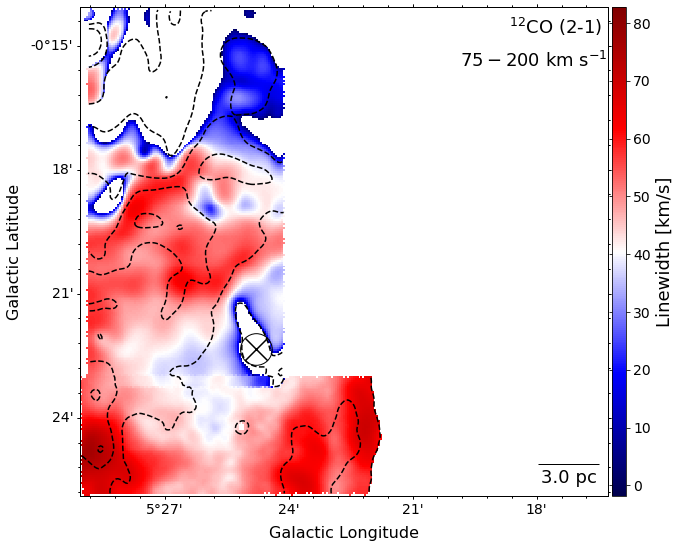

In [20]:
cube17a_2 = cube_17a.with_mask(mask_17a).spectral_slab(75*u.km / u.second, 200*u.km/u.second).linewidth_fwhm()
mask_17a_2 = cube17a_0 > 143.81665016 * u.K * u.km / u.second
cube17a_2 = (cube17a_2*mask_17a_2)
cube17a_2[cube17a_2==0] = np.nan
cube17a_2.quicklook()
cube17a_2.FITSFigure.show_colorscale(cmap='seismic')
cube17a_2.FITSFigure.colorbar.set_axis_label_text('Linewidth [km/s]')
levsa = cube17a_2.FITSFigure.show_contour(cube17a_0.hdu, returnlevels=True, linestyles='dashed', colors='black')
cube17a_2.FITSFigure.colorbar.set_axis_label_font(size=18)
cube17a_2.FITSFigure.colorbar.set_font(size=14)
cube17a_2.FITSFigure.axis_labels.set_font(size=16)
cube17a_2.FITSFigure.tick_labels.set_font(size=14)
cube17a_2.FITSFigure.add_label(0.9, 0.96, "$^{12}$CO (2-1)", relative=True, size=18)
cube17a_2.FITSFigure.add_label(0.86, 0.89, "$75-200$ km s$^{-1}$", relative=True, size=18)
cube17a_2.FITSFigure.add_scalebar(ang, color='black', size=18)
cube17a_2.FITSFigure.scalebar.set_label(m)
cube17a_2.FITSFigure.show_markers(coord.to_pixel(wcs=cube17_2.wcs)[0], coord.to_pixel(wcs=cube17_2.wcs)[1], coords_frame='pixel', layer=True, c='none', edgecolor='black', s=1000)
cube17a_2.FITSFigure.show_markers(coord.l, coord.b, marker='x', c='black', s=500)
#cube17a_2.FITSFigure.savefig('/orange/adamginsburg/cmz/g5/code/plots/mom2_G5a_17-new.pdf')

In [21]:
levsa

array([-12.73765901, 150.1688914 , 313.0754418 , 475.98199221,
       638.88854261])

INFO: Auto-setting vmin to  1.511e+01 [aplpy.core]
INFO: Auto-setting vmax to  4.712e+01 [aplpy.core]
INFO: Auto-setting vmin to  1.325e+01 [aplpy.core]
INFO: Auto-setting vmax to  4.679e+01 [aplpy.core]


/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/aplpy/overlays.py:272: UserWarning: Scalebar does not have attribute size. Skipping.
  warnings.warn("Scalebar does not have attribute {0}. Skipping.".format(kwarg))


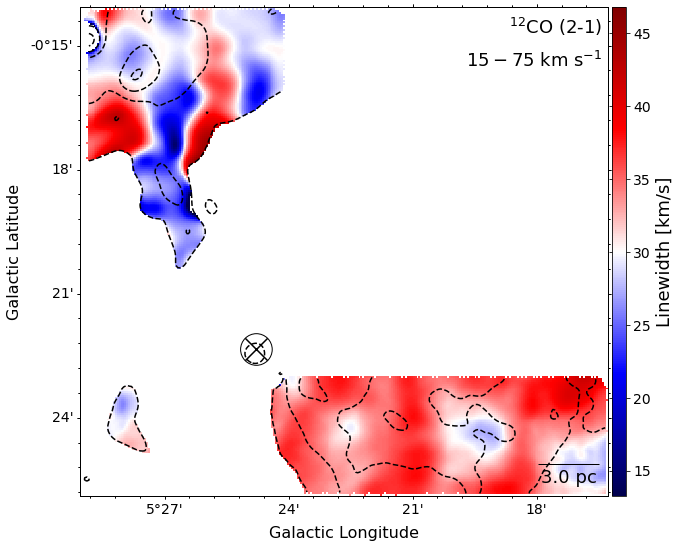

In [22]:
cube17b_2 = cube_17b.with_mask(mask_17b).spectral_slab(15*u.km / u.second, 75*u.km/u.second).linewidth_fwhm()
mask_17b_2 = cube17b_0 > 84.70658828 * u.K * u.km / u.second
cube17b_2 = (cube17b_2*mask_17b_2)
cube17b_2[cube17b_2==0] = np.nan
cube17b_2.quicklook()
cube17b_2.FITSFigure.show_colorscale(cmap='seismic')
cube17b_2.FITSFigure.colorbar.set_axis_label_text('Linewidth [km/s]')
levsb = cube17b_2.FITSFigure.show_contour(cube17b_0.hdu, returnlevels=True, linestyles='dashed', colors='black')
cube17b_2.FITSFigure.colorbar.set_axis_label_font(size=18)
cube17b_2.FITSFigure.colorbar.set_font(size=14)
cube17b_2.FITSFigure.axis_labels.set_font(size=16)
cube17b_2.FITSFigure.tick_labels.set_font(size=14)
cube17b_2.FITSFigure.add_label(0.9, 0.96, "$^{12}$CO (2-1)", relative=True, size=18)
cube17b_2.FITSFigure.add_label(0.86, 0.89, "$15-75$ km s$^{-1}$", relative=True, size=18)
cube17b_2.FITSFigure.add_scalebar(ang, color='black', size=18)
cube17b_2.FITSFigure.scalebar.set_label(m)
cube17b_2.FITSFigure.show_markers(coord.to_pixel(wcs=cube17_2.wcs)[0], coord.to_pixel(wcs=cube17_2.wcs)[1], coords_frame='pixel', layer=True, c='none', edgecolor='black', s=1000)
cube17b_2.FITSFigure.show_markers(coord.l, coord.b, marker='x', c='black', s=500)
#cube17b_2.FITSFigure.savefig('/orange/adamginsburg/cmz/g5/code/plots/mom2_G5b_17-new.pdf')

In [23]:
levsb

array([-17.3388571 ,  88.90221306, 195.14328323, 301.38435339,
       407.62542355])

INFO: Auto-setting vmin to -6.538e-01 [aplpy.core]
INFO: Auto-setting vmax to  1.867e+00 [aplpy.core]
INFO: Auto-setting vmin to -5.052e-01 [aplpy.core]
INFO: Auto-setting vmax to  1.847e+00 [aplpy.core]


/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/aplpy/overlays.py:272: UserWarning: Scalebar does not have attribute size. Skipping.
  warnings.warn("Scalebar does not have attribute {0}. Skipping.".format(kwarg))


INFO: Auto-setting resolution to 35.3201 dpi [aplpy.core]


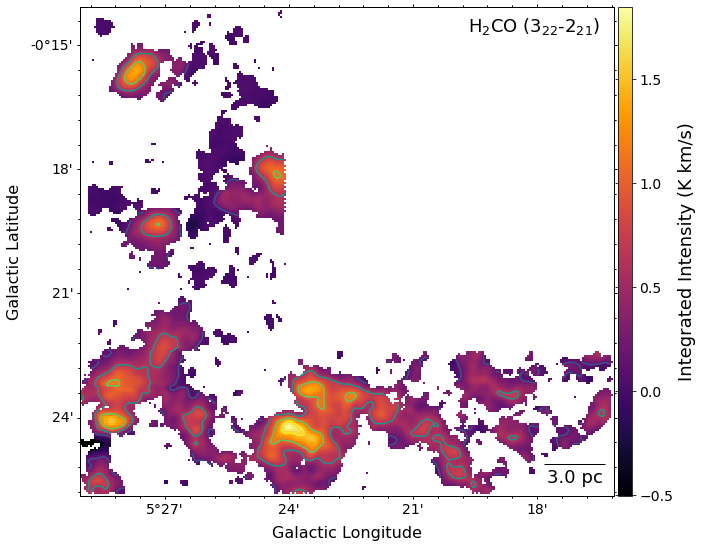

In [24]:
cube23_0 = cube_23.with_mask(mask_23).spectral_slab(-5*u.km / u.second, 200*u.km/u.second).moment0()
cube23_0.quicklook()
cube23_0.FITSFigure.show_colorscale(cmap='inferno')
cube23_0.FITSFigure.colorbar.set_axis_label_text('Integrated Intensity (K km/s)')
cube23_0.FITSFigure.show_contour(cube23_0.hdu, returnlevels=True)
cube23_0.FITSFigure.colorbar.set_axis_label_font(size=18)
cube23_0.FITSFigure.colorbar.set_font(size=14)
cube23_0.FITSFigure.axis_labels.set_font(size=16)
cube23_0.FITSFigure.tick_labels.set_font(size=14)
cube23_0.FITSFigure.add_label(0.85, 0.96, "H$_2$CO (3$_{22}$-2$_{21}$)", relative=True, size=18)
cube23_0.FITSFigure.add_scalebar(ang, color='black', size=18)
cube23_0.FITSFigure.scalebar.set_label(m)
cube23_0.FITSFigure.savefig('/orange/adamginsburg/cmz/g5/code/plots/mom0_23-new.pdf')

/blue/adamginsburg/adamginsburg/repos/spectral-cube/spectral_cube/spectral_cube.py:439: RuntimeWarning: All-NaN slice encountered
  out = function(self._get_filled_data(fill=fill,


INFO: Auto-setting vmin to  3.200e-03 [aplpy.core]
INFO: Auto-setting vmax to  1.184e-01 [aplpy.core]
INFO: Auto-setting vmin to  3.897e-03 [aplpy.core]
INFO: Auto-setting vmax to  1.156e-01 [aplpy.core]


/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/aplpy/overlays.py:272: UserWarning: Scalebar does not have attribute size. Skipping.
  warnings.warn("Scalebar does not have attribute {0}. Skipping.".format(kwarg))


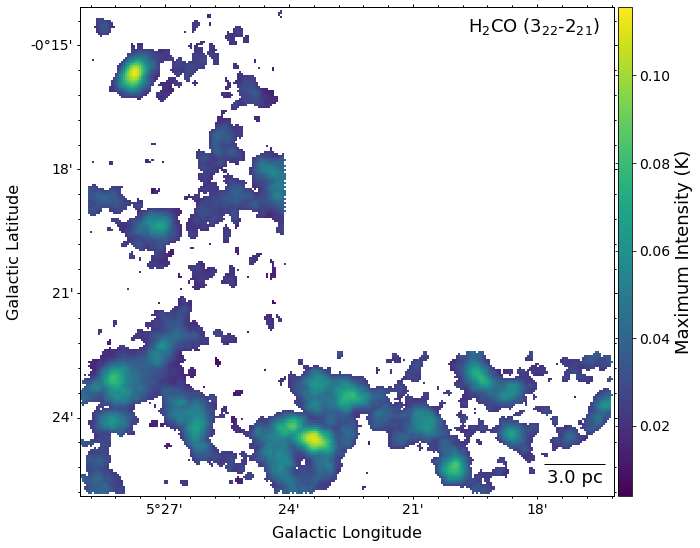

In [25]:
cube23_max = cube_23.with_mask(mask_23).spectral_slab(-5*u.km / u.second, 200*u.km/u.second).max(axis=0)
cube23_max.quicklook()
cube23_max.FITSFigure.show_colorscale(cmap='viridis')
cube23_max.FITSFigure.colorbar.set_axis_label_text('Maximum Intensity (K)')
#cube23_max.FITSFigure.show_contour(cube23_0.hdu, returnlevels=True)
cube23_max.FITSFigure.colorbar.set_axis_label_font(size=18)
cube23_max.FITSFigure.colorbar.set_font(size=14)
cube23_max.FITSFigure.axis_labels.set_font(size=16)
cube23_max.FITSFigure.tick_labels.set_font(size=14)
cube23_max.FITSFigure.add_label(0.85, 0.96, "H$_2$CO (3$_{22}$-2$_{21}$)", relative=True, size=18)
cube23_max.FITSFigure.add_scalebar(ang, color='black', size=18)
cube23_max.FITSFigure.scalebar.set_label(m)
#cube23_0.FITSFigure.savefig('/orange/adamginsburg/cmz/g5/code/plots/mom0_23-new.pdf')

INFO: Auto-setting vmin to -1.747e+00 [aplpy.core]
INFO: Auto-setting vmax to  6.104e+00 [aplpy.core]
INFO: Auto-setting vmin to -1.934e+00 [aplpy.core]
INFO: Auto-setting vmax to  5.889e+00 [aplpy.core]


/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/aplpy/overlays.py:272: UserWarning: Scalebar does not have attribute size. Skipping.
  warnings.warn("Scalebar does not have attribute {0}. Skipping.".format(kwarg))


INFO: Auto-setting resolution to 35.3201 dpi [aplpy.core]


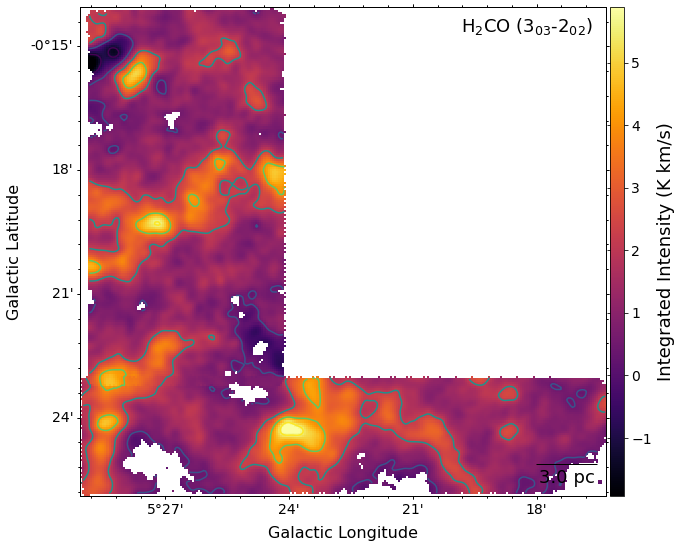

In [34]:
cube25_0 = cube_25.with_mask(mask_25).spectral_slab(-5*u.km / u.second, 200*u.km/u.second).moment0()
cube25_0.quicklook()
cube25_0.FITSFigure.show_colorscale(cmap='inferno')
cube25_0.FITSFigure.colorbar.set_axis_label_text('Integrated Intensity (K km/s)')
levs_25 = cube25_0.FITSFigure.show_contour(cube25_0.hdu, returnlevels=True)
cube25_0.FITSFigure.colorbar.set_axis_label_font(size=18)
cube25_0.FITSFigure.colorbar.set_font(size=14)
cube25_0.FITSFigure.axis_labels.set_font(size=16)
cube25_0.FITSFigure.tick_labels.set_font(size=14)
cube25_0.FITSFigure.add_label(0.85, 0.96, "H$_2$CO (3$_{03}$-2$_{02}$)", relative=True, size=18)
cube25_0.FITSFigure.add_scalebar(ang, color='black', size=18)
cube25_0.FITSFigure.scalebar.set_label(m)
cube25_0.FITSFigure.savefig('/orange/adamginsburg/cmz/g5/code/plots/mom0_25-new.pdf')

In [35]:
levs_25

array([-1.21069178,  0.48469524,  2.18008226,  3.87546928,  5.5708563 ])

In [36]:
np.nanmax(cube25_0)

<Projection 6.31627606 K km / s>

/blue/adamginsburg/adamginsburg/repos/spectral-cube/spectral_cube/spectral_cube.py:439: RuntimeWarning: All-NaN slice encountered
  out = function(self._get_filled_data(fill=fill,


INFO: Auto-setting vmin to -4.251e-03 [aplpy.core]
INFO: Auto-setting vmax to  2.793e-01 [aplpy.core]
INFO: Auto-setting vmin to -5.687e-03 [aplpy.core]
INFO: Auto-setting vmax to  2.922e-01 [aplpy.core]


/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/aplpy/overlays.py:272: UserWarning: Scalebar does not have attribute size. Skipping.
  warnings.warn("Scalebar does not have attribute {0}. Skipping.".format(kwarg))


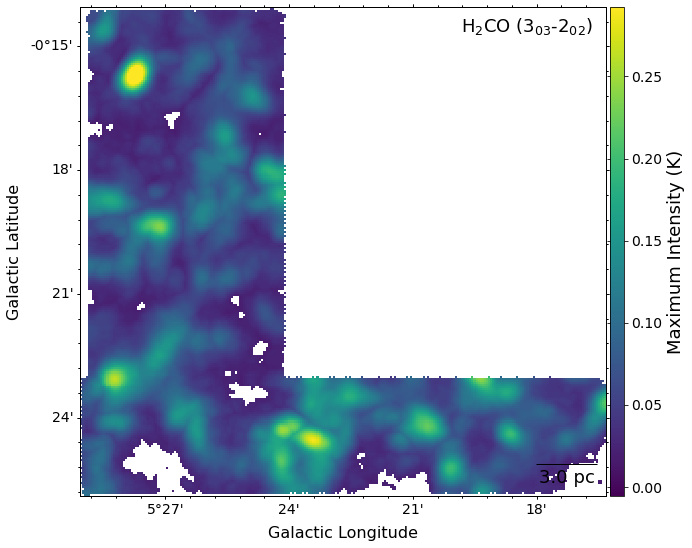

In [27]:
cube25_max = cube_25.with_mask(mask_25).spectral_slab(-5*u.km / u.second, 200*u.km/u.second).max(axis=0)
cube25_max.quicklook()
cube25_max.FITSFigure.show_colorscale(cmap='viridis')
cube25_max.FITSFigure.colorbar.set_axis_label_text('Maximum Intensity (K)')
#cube25_max.FITSFigure.show_contour(cube25_0.hdu, returnlevels=True)
cube25_max.FITSFigure.colorbar.set_axis_label_font(size=18)
cube25_max.FITSFigure.colorbar.set_font(size=14)
cube25_max.FITSFigure.axis_labels.set_font(size=16)
cube25_max.FITSFigure.tick_labels.set_font(size=14)
cube25_max.FITSFigure.add_label(0.85, 0.96, "H$_2$CO (3$_{03}$-2$_{02}$)", relative=True, size=18)
cube25_max.FITSFigure.add_scalebar(ang, color='black', size=18)
cube25_max.FITSFigure.scalebar.set_label(m)
#cube25_0.FITSFigure.savefig('/orange/adamginsburg/cmz/g5/code/plots/mom0_25-new.pdf')

INFO: Auto-setting vmin to -9.915e-01 [aplpy.core]
INFO: Auto-setting vmax to  4.992e+00 [aplpy.core]
INFO: Auto-setting vmin to -9.549e-01 [aplpy.core]
INFO: Auto-setting vmax to  4.496e+00 [aplpy.core]


/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/aplpy/overlays.py:272: UserWarning: Scalebar does not have attribute size. Skipping.
  warnings.warn("Scalebar does not have attribute {0}. Skipping.".format(kwarg))


INFO: Auto-setting resolution to 35.0258 dpi [aplpy.core]


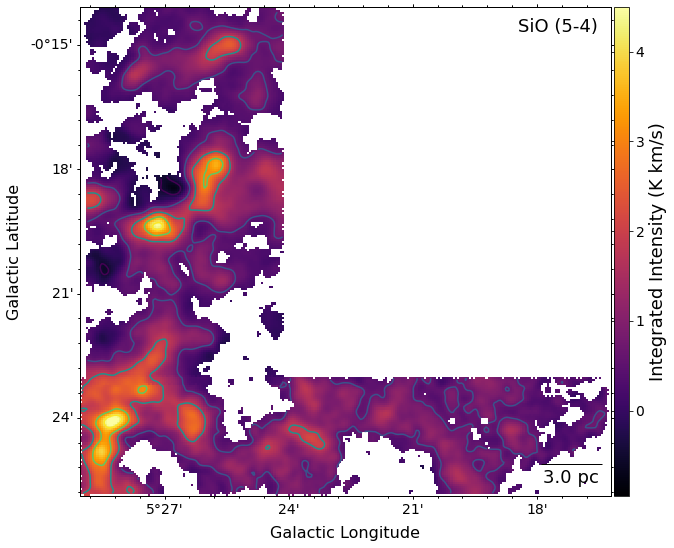

In [37]:
cube27_0 = cube_27.with_mask(mask_27).spectral_slab(-5*u.km / u.second, 200*u.km/u.second).moment0()
cube27_0.quicklook()
cube27_0.FITSFigure.show_colorscale(cmap='inferno')
cube27_0.FITSFigure.colorbar.set_axis_label_text('Integrated Intensity (K km/s)')
levs_27 = cube27_0.FITSFigure.show_contour(cube27_0.hdu, returnlevels=True)
cube27_0.FITSFigure.colorbar.set_axis_label_font(size=18)
cube27_0.FITSFigure.colorbar.set_font(size=14)
cube27_0.FITSFigure.axis_labels.set_font(size=16)
cube27_0.FITSFigure.tick_labels.set_font(size=14)
cube27_0.FITSFigure.add_label(0.9, 0.96, "SiO (5-4)", relative=True, size=18)
cube27_0.FITSFigure.add_scalebar(ang, color='black', size=18)
cube27_0.FITSFigure.scalebar.set_label(m)
cube27_0.FITSFigure.savefig('/orange/adamginsburg/cmz/g5/code/plots/mom0_27-new.pdf')

In [38]:
levs_27

array([-0.47110417,  0.68143673,  1.83397763,  2.98651853,  4.13905943])

In [39]:
np.nanmax(cube27_0)

<Projection 4.79420763 K km / s>

/blue/adamginsburg/adamginsburg/repos/spectral-cube/spectral_cube/spectral_cube.py:439: RuntimeWarning: All-NaN slice encountered
  out = function(self._get_filled_data(fill=fill,


INFO: Auto-setting vmin to -2.684e-03 [aplpy.core]
INFO: Auto-setting vmax to  2.285e-01 [aplpy.core]
INFO: Auto-setting vmin to -2.694e-03 [aplpy.core]
INFO: Auto-setting vmax to  2.376e-01 [aplpy.core]


/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/aplpy/overlays.py:272: UserWarning: Scalebar does not have attribute size. Skipping.
  warnings.warn("Scalebar does not have attribute {0}. Skipping.".format(kwarg))


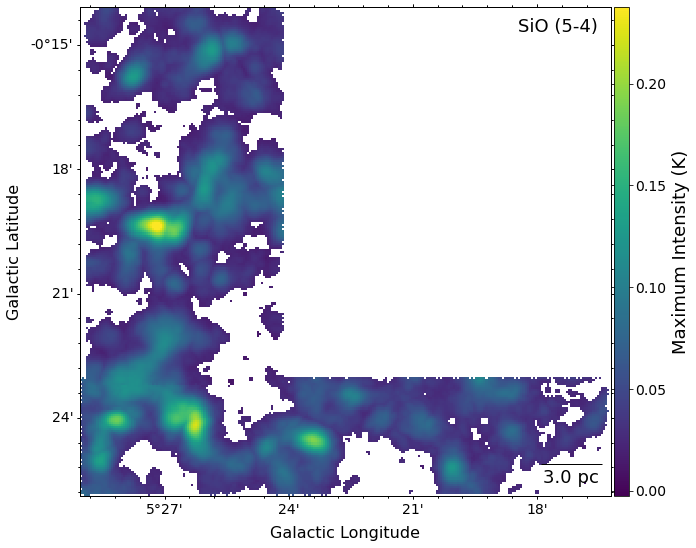

In [29]:
cube27_max = cube_27.with_mask(mask_27).spectral_slab(-5*u.km / u.second, 200*u.km/u.second).max(axis=0)
cube27_max.quicklook()
cube27_max.FITSFigure.show_colorscale(cmap='viridis')
cube27_max.FITSFigure.colorbar.set_axis_label_text('Maximum Intensity (K)')
#cube27_max.FITSFigure.show_contour(cube27_0.hdu, returnlevels=True)
cube27_max.FITSFigure.colorbar.set_axis_label_font(size=18)
cube27_max.FITSFigure.colorbar.set_font(size=14)
cube27_max.FITSFigure.axis_labels.set_font(size=16)
cube27_max.FITSFigure.tick_labels.set_font(size=14)
cube27_max.FITSFigure.add_label(0.9, 0.96, "SiO (5-4)", relative=True, size=18)
cube27_max.FITSFigure.add_scalebar(ang, color='black', size=18)
cube27_max.FITSFigure.scalebar.set_label(m)
#cube27_0.FITSFigure.savefig('/orange/adamginsburg/cmz/g5/code/plots/mom0_27-new.pdf')

INFO: Auto-setting vmin to -8.901e+00 [aplpy.core]
INFO: Auto-setting vmax to  6.272e+01 [aplpy.core]
INFO: Auto-setting vmin to -9.842e+00 [aplpy.core]
INFO: Auto-setting vmax to  6.401e+01 [aplpy.core]


/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/aplpy/overlays.py:272: UserWarning: Scalebar does not have attribute size. Skipping.
  warnings.warn("Scalebar does not have attribute {0}. Skipping.".format(kwarg))


INFO: Auto-setting resolution to 35.6144 dpi [aplpy.core]


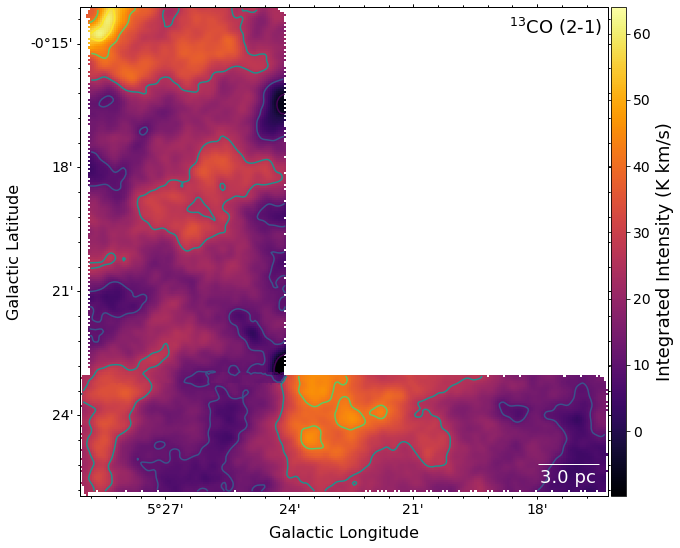

In [30]:
cube29_0 = cube_29.with_mask(mask_29).spectral_slab(15*u.km / u.second, 200*u.km/u.second).moment0()
cube29_0.quicklook()
cube29_0.FITSFigure.show_colorscale(cmap='inferno')
cube29_0.FITSFigure.colorbar.set_axis_label_text('Integrated Intensity (K km/s)')
cube29_0.FITSFigure.show_contour(cube29_0.hdu, returnlevels=True)
cube29_0.FITSFigure.colorbar.set_axis_label_font(size=18)
cube29_0.FITSFigure.colorbar.set_font(size=14)
cube29_0.FITSFigure.axis_labels.set_font(size=16)
cube29_0.FITSFigure.tick_labels.set_font(size=14)
cube29_0.FITSFigure.add_label(0.9, 0.96, "$^{13}$CO (2-1)", relative=True, size=18)
cube29_0.FITSFigure.add_scalebar(ang, color='white', size=18)
cube29_0.FITSFigure.scalebar.set_label(m)
cube29_0.FITSFigure.savefig('/orange/adamginsburg/cmz/g5/code/plots/mom0_29-new.pdf')

/blue/adamginsburg/adamginsburg/repos/spectral-cube/spectral_cube/spectral_cube.py:439: RuntimeWarning: All-NaN slice encountered
  out = function(self._get_filled_data(fill=fill,


INFO: Auto-setting vmin to -3.925e-01 [aplpy.core]
INFO: Auto-setting vmax to  7.094e+00 [aplpy.core]
INFO: Auto-setting vmin to -4.121e-01 [aplpy.core]
INFO: Auto-setting vmax to  7.429e+00 [aplpy.core]


/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/aplpy/overlays.py:272: UserWarning: Scalebar does not have attribute size. Skipping.
  warnings.warn("Scalebar does not have attribute {0}. Skipping.".format(kwarg))


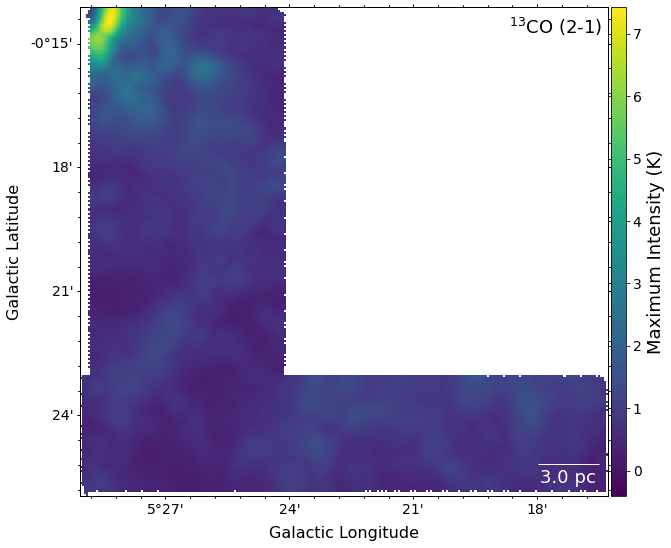

In [31]:
cube29_max = cube_29.with_mask(mask_29).spectral_slab(15*u.km / u.second, 200*u.km/u.second).max(axis=0)
cube29_max.quicklook()
cube29_max.FITSFigure.show_colorscale(cmap='viridis')
cube29_max.FITSFigure.colorbar.set_axis_label_text('Maximum Intensity (K)')
#cube29_max.FITSFigure.show_contour(cube29_0.hdu, returnlevels=True)
cube29_max.FITSFigure.colorbar.set_axis_label_font(size=18)
cube29_max.FITSFigure.colorbar.set_font(size=14)
cube29_max.FITSFigure.axis_labels.set_font(size=16)
cube29_max.FITSFigure.tick_labels.set_font(size=14)
cube29_max.FITSFigure.add_label(0.9, 0.96, "$^{13}$CO (2-1)", relative=True, size=18)
cube29_max.FITSFigure.add_scalebar(ang, color='white', size=18)
cube29_max.FITSFigure.scalebar.set_label(m)
#cube29_0.FITSFigure.savefig('/orange/adamginsburg/cmz/g5/code/plots/mom0_29-new.pdf')

INFO: Auto-setting vmin to -1.660e+00 [aplpy.core]
INFO: Auto-setting vmax to  1.083e+01 [aplpy.core]
INFO: Auto-setting vmin to -1.802e+00 [aplpy.core]
INFO: Auto-setting vmax to  1.083e+01 [aplpy.core]


/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/aplpy/overlays.py:272: UserWarning: Scalebar does not have attribute size. Skipping.
  warnings.warn("Scalebar does not have attribute {0}. Skipping.".format(kwarg))


INFO: Auto-setting resolution to 35.4673 dpi [aplpy.core]


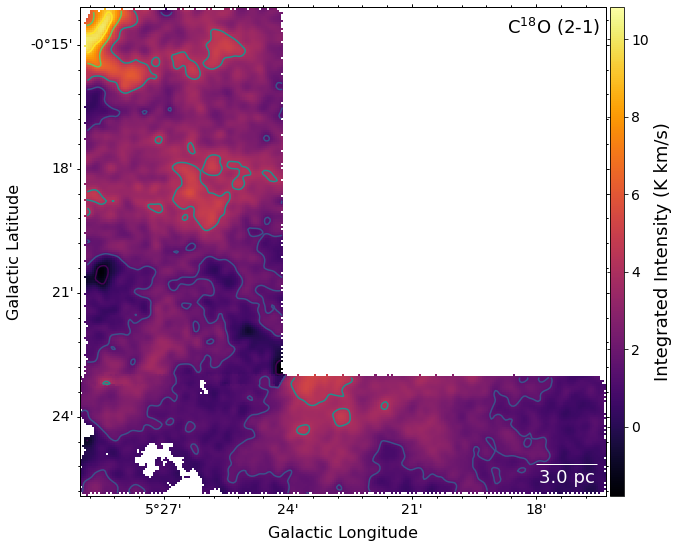

In [32]:
cube31_0 = cube_31.with_mask(mask_31).spectral_slab(15*u.km / u.second, 200*u.km/u.second).moment0()
cube31_0.quicklook()
cube31_0.FITSFigure.show_colorscale(cmap='inferno')
cube31_0.FITSFigure.colorbar.set_axis_label_text('Integrated Intensity (K km/s)')
cube31_0.FITSFigure.show_contour(cube31_0.hdu, returnlevels=True)
cube31_0.FITSFigure.colorbar.set_axis_label_font(size=18)
cube31_0.FITSFigure.colorbar.set_font(size=14)
cube31_0.FITSFigure.axis_labels.set_font(size=16)
cube31_0.FITSFigure.tick_labels.set_font(size=14)
cube31_0.FITSFigure.add_label(0.9, 0.96, "C$^{18}$O (2-1)", relative=True, size=18)
cube31_0.FITSFigure.add_scalebar(ang, color='white', size=18)
cube31_0.FITSFigure.scalebar.set_label(m)
cube31_0.FITSFigure.savefig('/orange/adamginsburg/cmz/g5/code/plots/mom0_31-new.pdf')

/blue/adamginsburg/adamginsburg/repos/spectral-cube/spectral_cube/spectral_cube.py:439: RuntimeWarning: All-NaN slice encountered
  out = function(self._get_filled_data(fill=fill,


INFO: Auto-setting vmin to -1.216e-01 [aplpy.core]
INFO: Auto-setting vmax to  1.828e+00 [aplpy.core]
INFO: Auto-setting vmin to -1.168e-01 [aplpy.core]
INFO: Auto-setting vmax to  1.756e+00 [aplpy.core]


/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/aplpy/overlays.py:272: UserWarning: Scalebar does not have attribute size. Skipping.
  warnings.warn("Scalebar does not have attribute {0}. Skipping.".format(kwarg))


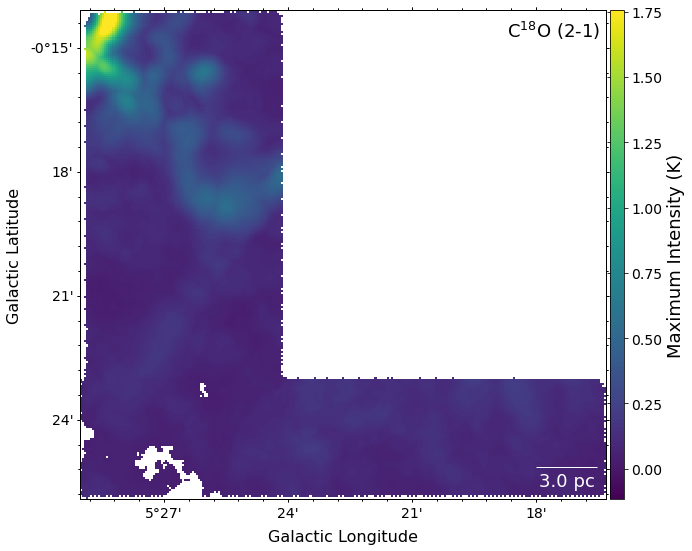

In [33]:
cube31_max = cube_31.with_mask(mask_31).spectral_slab(15*u.km / u.second, 200*u.km/u.second).max(axis=0)
cube31_max.quicklook()
cube31_max.FITSFigure.show_colorscale(cmap='viridis')
cube31_max.FITSFigure.colorbar.set_axis_label_text('Maximum Intensity (K)')
#cube31_max.FITSFigure.show_contour(cube31_0.hdu, returnlevels=True)
cube31_max.FITSFigure.colorbar.set_axis_label_font(size=18)
cube31_max.FITSFigure.colorbar.set_font(size=14)
cube31_max.FITSFigure.axis_labels.set_font(size=16)
cube31_max.FITSFigure.tick_labels.set_font(size=14)
cube31_max.FITSFigure.add_label(0.9, 0.96, "C$^{18}$O (2-1)", relative=True, size=18)
cube31_max.FITSFigure.add_scalebar(ang, color='white', size=18)
cube31_max.FITSFigure.scalebar.set_label(m)
#cube31_0.FITSFigure.savefig('/orange/adamginsburg/cmz/g5/code/plots/mom0_31-new.pdf')

In [41]:
cube_25a = cube_25.spectral_slab(55*u.km/u.second, 225*u.km/u.second)
cube_25b = cube_25.spectral_slab(-5*u.km/u.second, 55*u.km/u.second)
mask_25b = noise_mask_slab(cube_25, -100*u.km/u.second, -50 *u.km/u.second, 5, -5*u.km/u.second, 55*u.km/u.second)
mask_25a = noise_mask_slab(cube_25, -100*u.km/u.second, -50 *u.km/u.second, 5, 55*u.km/u.second, 225*u.km/u.second)


/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/blue/adamginsburg/adamginsburg/repos/spectral-cube/spectral_cube/spectral_cube.py:439: RuntimeWarning: All-NaN slice encountered
  out = function(self._get_filled_data(fill=fill,
/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/blue/adamginsburg/adamginsburg/repos/spectral-cube/spectral_cube/spectral_cube.py:439: RuntimeWarning: All-NaN slice encountered
  out = function(self._get_filled_data(fill=fill,


INFO: Auto-setting vmin to -3.837e-01 [aplpy.core]
INFO: Auto-setting vmax to  3.451e+00 [aplpy.core]
INFO: Auto-setting vmin to -3.765e-01 [aplpy.core]
INFO: Auto-setting vmax to  3.428e+00 [aplpy.core]


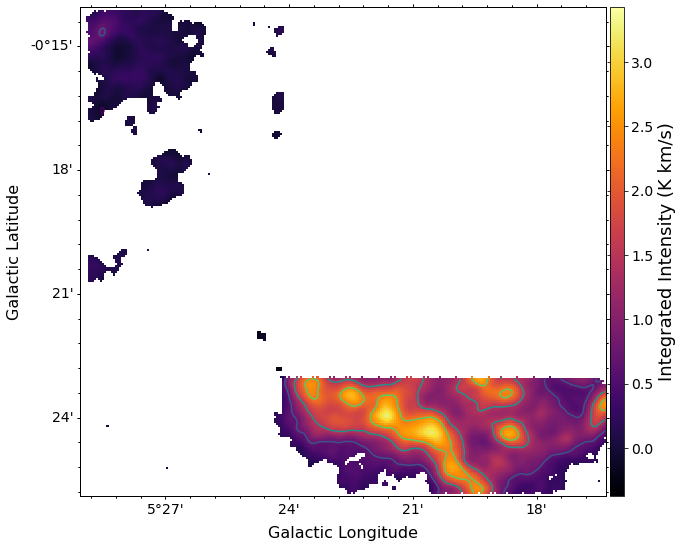

In [45]:
cube25b_0 = cube_25b.with_mask(mask_25b).moment0()#.with_mask(mask_17).moment0()
cube25b_0.quicklook()
cube25b_0.FITSFigure.show_colorscale(cmap='inferno')
cube25b_0.FITSFigure.colorbar.set_axis_label_text('Integrated Intensity (K km/s)')
levs_25b = cube25b_0.FITSFigure.show_contour(cube25b_0.hdu, returnlevels=True)
cube25b_0.FITSFigure.colorbar.set_axis_label_font(size=18)
cube25b_0.FITSFigure.colorbar.set_font(size=14)
cube25b_0.FITSFigure.axis_labels.set_font(size=16)
cube25b_0.FITSFigure.tick_labels.set_font(size=14)

In [46]:
levs_25b

array([-0.07112146,  0.71664655,  1.50441455,  2.29218255,  3.07995055])

In [47]:
np.nanmax(cube25b_0)

<Projection 3.23530056 K km / s>

INFO: Auto-setting vmin to -9.519e-01 [aplpy.core]
INFO: Auto-setting vmax to  5.974e+00 [aplpy.core]
INFO: Auto-setting vmin to -8.585e-01 [aplpy.core]
INFO: Auto-setting vmax to  5.877e+00 [aplpy.core]


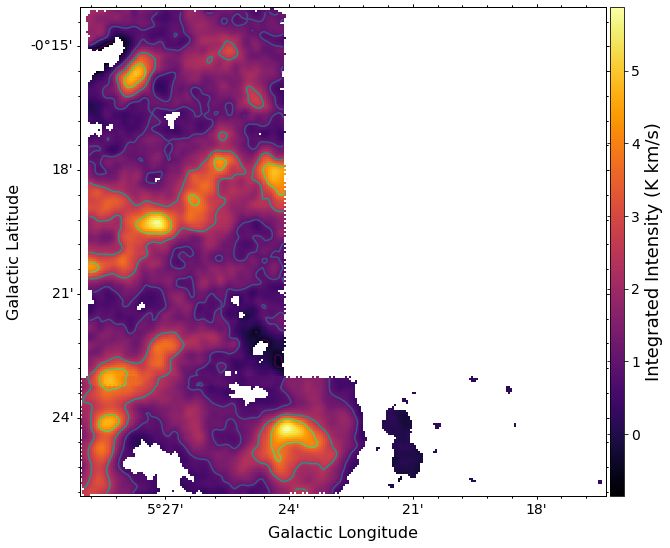

In [43]:
cube25a_0 = cube_25a.with_mask(mask_25a).moment0()#.with_mask(mask_17).moment0()
cube25a_0.quicklook()
cube25a_0.FITSFigure.show_colorscale(cmap='inferno')
cube25a_0.FITSFigure.colorbar.set_axis_label_text('Integrated Intensity (K km/s)')
levs_25a = cube25a_0.FITSFigure.show_contour(cube25a_0.hdu, returnlevels=True)
cube25a_0.FITSFigure.colorbar.set_axis_label_font(size=18)
cube25a_0.FITSFigure.colorbar.set_font(size=14)
cube25a_0.FITSFigure.axis_labels.set_font(size=16)
cube25a_0.FITSFigure.tick_labels.set_font(size=14)

In [48]:
levs_25a

array([-0.41993019,  1.0083759 ,  2.43668198,  3.86498807,  5.29329416])

In [49]:
np.nanmax(cube25a_0)

<Projection 5.84760859 K km / s>

In [53]:
std_27 = cube_27.with_spectral_unit(u.km/u.s, velocity_convention='radio').spectral_slab(-50*u.km/u.second, -100*u.km/u.second).moment0()#.std()

INFO: Auto-setting vmin to -1.731e-01 [aplpy.core]
INFO: Auto-setting vmax to  1.164e-01 [aplpy.core]


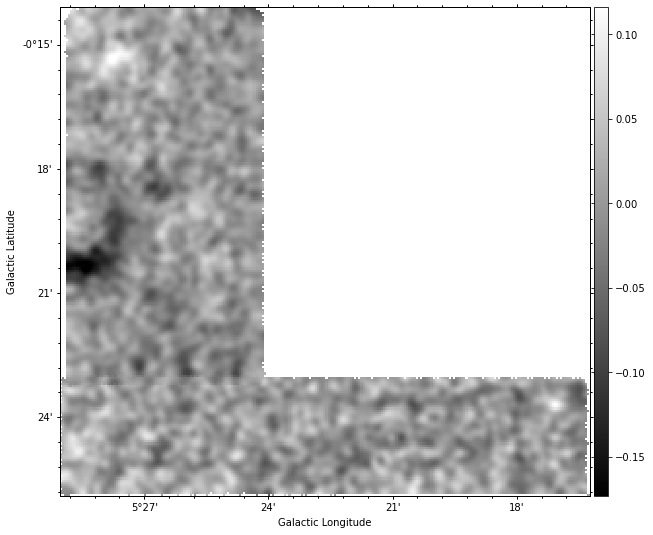

In [54]:
std_27.quicklook()

In [ ]:
std_27